In [11]:
import torch
from torch import tensor
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from ast import literal_eval
from py_experimenter.experimenter import PyExperimenter
import torch
import mysql.connector
import openml


from py_experimenter.database_connector_mysql import DatabaseConnectorMYSQL

# def connect(self):

#     db = mysql.connector.connect(
#         host="db01-kiml.kiml.ifi.lmu.de",
#         user="jonas_h",
#         password="thiswillnotactuallybevalidforverylongsodontcountonit",
#         database="jonas_test",
#         ssl_disabled=False,
#     )
#     return db


# def _start_transaction(self, connection, readonly=False):
#     if not readonly:
#         connection.start_transaction()


# DatabaseConnectorMYSQL.connect = connect
# DatabaseConnectorMYSQL._start_transaction = _start_transaction

%matplotlib inline

In [12]:
experimenter = PyExperimenter(
    experiment_configuration_file_path="./experiments/config/cfg_simple_debug.yml",
)
exp_frame = experimenter.get_table()
# exp_frame = exp_frame[exp_frame.fraction_cal_samples >= 0.19999]
# exp_frame = exp_frame[exp_frame.openml_id != 4534]
# exp_frame = exp_frame[exp_frame.openml_id != 15]
exp_frame = exp_frame[exp_frame.openml_id != 41]
# exp_frame = exp_frame[exp_frame. != 41]
# exp_frame = exp_frame[exp_frame.openml_id != 31]


2025-02-06 10:50:13,310  | py-experimenter - INFO     | Found 4 keyfields
2025-02-06 10:50:13,314  | py-experimenter - INFO     | Found 2 resultfields
2025-02-06 10:50:13,317  | py-experimenter - INFO     | Found 1 logtables
2025-02-06 10:50:13,320  | py-experimenter - INFO     | Found logtable cp_rank_dev__new_cross__results
2025-02-06 10:50:13,323  | py-experimenter - WARNING  | No custom section defined in config
2025-02-06 10:50:13,325  | py-experimenter - WARNING  | No codecarbon section defined in config
2025-02-06 10:50:13,328  | py-experimenter - INFO     | Initialized and connected to database


In [13]:
import numpy as np
datasets = {}
num_classes = {}
dataset_renamer = {}
for id in exp_frame.openml_id.unique():
    dataset = openml.datasets.get_dataset(id.item())
    target_attribute = dataset.default_target_attribute
    X, y, _, _ = dataset.get_data(target=target_attribute)
    datasets[id] = dataset
    dataset_renamer[id] = dataset.name
    num_classes[id] = len(np.unique(y))

In [14]:
logtable = experimenter.get_logtable("results")
result_df = pd.merge(exp_frame, logtable, left_on="ID", right_on="experiment_id")

In [15]:
result_df = result_df[result_df.conformity_score.isin(["rand_aps","aps", "thr", "ranker_vanilla"])] 

In [16]:
result_df.conformity_score

0             rand_aps
1             rand_aps
2             rand_aps
3                  aps
4                  aps
             ...      
2083    ranker_vanilla
2084    ranker_vanilla
2091    ranker_vanilla
2092    ranker_vanilla
2093    ranker_vanilla
Name: conformity_score, Length: 840, dtype: object

In [17]:
result_df.columns

Index(['ID_x', 'model', 'openml_id', 'master_seed', 'fraction_cal_samples',
       'creation_date', 'status', 'start_date', 'name', 'machine',
       'clf_seed_x', 'mccv_seed_x', 'end_date', 'error', 'ID_y',
       'experiment_id', 'timestamp', 'coverage_rate', 'average_size',
       'cov_gap', 'vio_classes', 'sscv', 'wsc', 'acc', 'bacc',
       'conformity_score', 'alpha', 'gradient_updates', 'clf_seed_y',
       'mccv_seed_y', 'len_train', 'len_test', 'len_cal'],
      dtype='object')

In [18]:
df = result_df

result_df["dataset"] =  result_df["openml_id"].replace(dataset_renamer)
result_df["num_classes"] = result_df["openml_id"].replace(num_classes)

result_df["dataset"] = result_df["dataset"] + " (" + result_df["num_classes"].astype(str) + ")"

cs_renamer = {"aps":"APS",
              "rand_aps": "APS (rand)",
              "thr": "LAC",
              "ranker_vanilla": " "}


model_renamer = {"ranker":"Ranker",
              "classifier": "Classifier"}


result_df["conformity_score"] =  result_df["conformity_score"].replace(cs_renamer)
result_df["model"] =  result_df["model"].replace(model_renamer)

result_df["method"] = result_df["model"] + " " + result_df["conformity_score"]
# result_df = result_df.sort_values(by="num_classes", ascending=True)
# group_cols = ['dataset', 'alpha', 'fraction_cal_samples', 'model']
group_cols = ['dataset', 'alpha', 'method']
metrics_max = ['acc','coverage_rate']
metrics_min = ['average_size']
metrics = metrics_max + metrics_min

grouped_df = result_df.groupby(group_cols).agg({metric: 'mean' for metric in metrics}).reset_index()


# grouped_df = grouped_df.sort_values(by='num_classes', ascending=True)
agg_dict = {metric: 'max' for metric in metrics_max}
agg_dict.update({metric: 'min' for metric in metrics_min})
# grouped_df = grouped_df[grouped_df.method.isin(["classifier + APS"])]
best_values = grouped_df.groupby(['dataset', 'alpha']).agg(agg_dict).reset_index()
# group_cols = ['dataset', 'alpha', 'method']
# grouped_df = grouped_df.drop(["num_classes"], axis=1)

In [9]:
def generate_latex_table_with_lines(df, group_cols, value_cols, best_values):
    """Generate a LaTeX table with multirow entries, bold the best values, and add lines between consecutive multirows."""
    
    def format_value(value, group, metric, max=True):
        """Format the value, making the highest value bold."""
        max_value = best_values.loc[
            (best_values['dataset'] == group['dataset']) & 
            (best_values['alpha'] == group['alpha']), metric].values[0]
            # (best_values['fraction_cal_samples'] == group['fraction_cal_samples']), metric].values[0]
        if value == max_value:
            return f"\\textbf{{{value:.4f}}}"
        else:
            return f"{value:.4f}"
    
    def recursive_build(df, group_cols):
        # if len(group_cols) == 1:
            # Base case: only one group left, print it directly
            latex_str = ""
            prev_row = None
            for row_id, row in df.iterrows():
                latex_str_tmp = ""
                col_id_list = []
                for col_id, col in enumerate(group_cols):
                    if prev_row is None or row[col] != prev_row[col]:
                        col_id_list.append(col_id)
                        filter_cols = group_cols[:col_id+1]
                        indices = []
                        values = []
                        for fcol in filter_cols:
                            indices.append(fcol)
                            values.append(row[fcol])
                        criteria = dict(zip(indices, values))
                        # Filter the DataFrame using query
                        mask = pd.Series([True] * len(df))

                        # Iterate over criteria to apply conditions
                        for key, value in criteria.items():
                            mask = mask & (df[key] == value)

                        # Filter the DataFrame
                        filtered_df = df[mask]

                        length = len(filtered_df)


                        latex_str_tmp += f" \\multirow{{{length}}}{{*}}{{{row[col]}}} & "
                        if col_id == len(group_cols) - 1:
                            latex_str_tmp += " & ".join([format_value(row[col], row, col) for col in value_cols]) + " \\\\\n"

                        # if prev_row is not None and col_id < len(group_cols) - 1:
                        # latex_str_tmp += " \\\\ \cline{%d-%d} \\\\" % (col_id + 1, len(group_cols) + len(value_cols))

                    else:
                        latex_str_tmp += " & "
                        if col_id == len(group_cols) - 1:
                            latex_str_tmp += " & ".join([format_value(row[col], row, col) for col in value_cols]) + " \\\\\n"
                if row_id > 0 and group_cols[min(col_id_list)] != "model":
                    latex_str += "\\cline{%d-%d}" % (min(col_id_list)+1, len(group_cols) + len(value_cols))
                latex_str += latex_str_tmp
                indices = []
                values = []
                prev_row = row
            return latex_str
        
    # Start recursive building
    latex_body = recursive_build(df, group_cols)

    # Complete LaTeX table
    num_columns = len(group_cols) + len(value_cols)
    col_format = 'l' * len(group_cols) + 'r' * len(value_cols)
    latex_table = f"""
\\begin{{tabular}}{{{col_format}}}
\\toprule
{' & '.join(group_cols)} & {' & '.join(value_cols)} \\\\
\\midrule
{latex_body}
\\bottomrule
\\end{{tabular}}
"""
    return latex_table

# Generate the LaTeX table with bold formatting and lines
latex_table = generate_latex_table_with_lines(grouped_df, group_cols, metrics, best_values)

# Print or save the LaTeX table
with open('out_table.tex', 'w') as f:
    print(latex_table.replace("_", "\_"), file=f)


In [10]:
grouped_df

,dataset,alpha,method,acc,coverage_rate,average_size
0,PhishingWebsites (2),0.05,Classifier APS,0.960832,0.987110,1.709543
1,PhishingWebsites (2),0.05,Classifier APS (rand),0.960832,0.954274,1.045681
2,PhishingWebsites (2),0.05,Classifier LAC,0.960832,0.954229,0.987562
3,PhishingWebsites (2),0.05,Ranker,0.960877,0.953867,0.987155
4,PhishingWebsites (2),0.10,Classifier APS,0.960832,0.986658,1.689688
...,...,...,...,...,...,...
79,wine (3),0.10,Ranker,0.983333,0.858333,0.858333
80,wine (3),0.20,Classifier APS,0.983333,0.813889,0.911111
81,wine (3),0.20,Classifier APS (rand),0.983333,0.780556,0.797222
82,wine (3),0.20,Classifier LAC,0.983333,0.777778,0.777778


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be remov

ValueError: Number of rows must be a positive integer, not 0

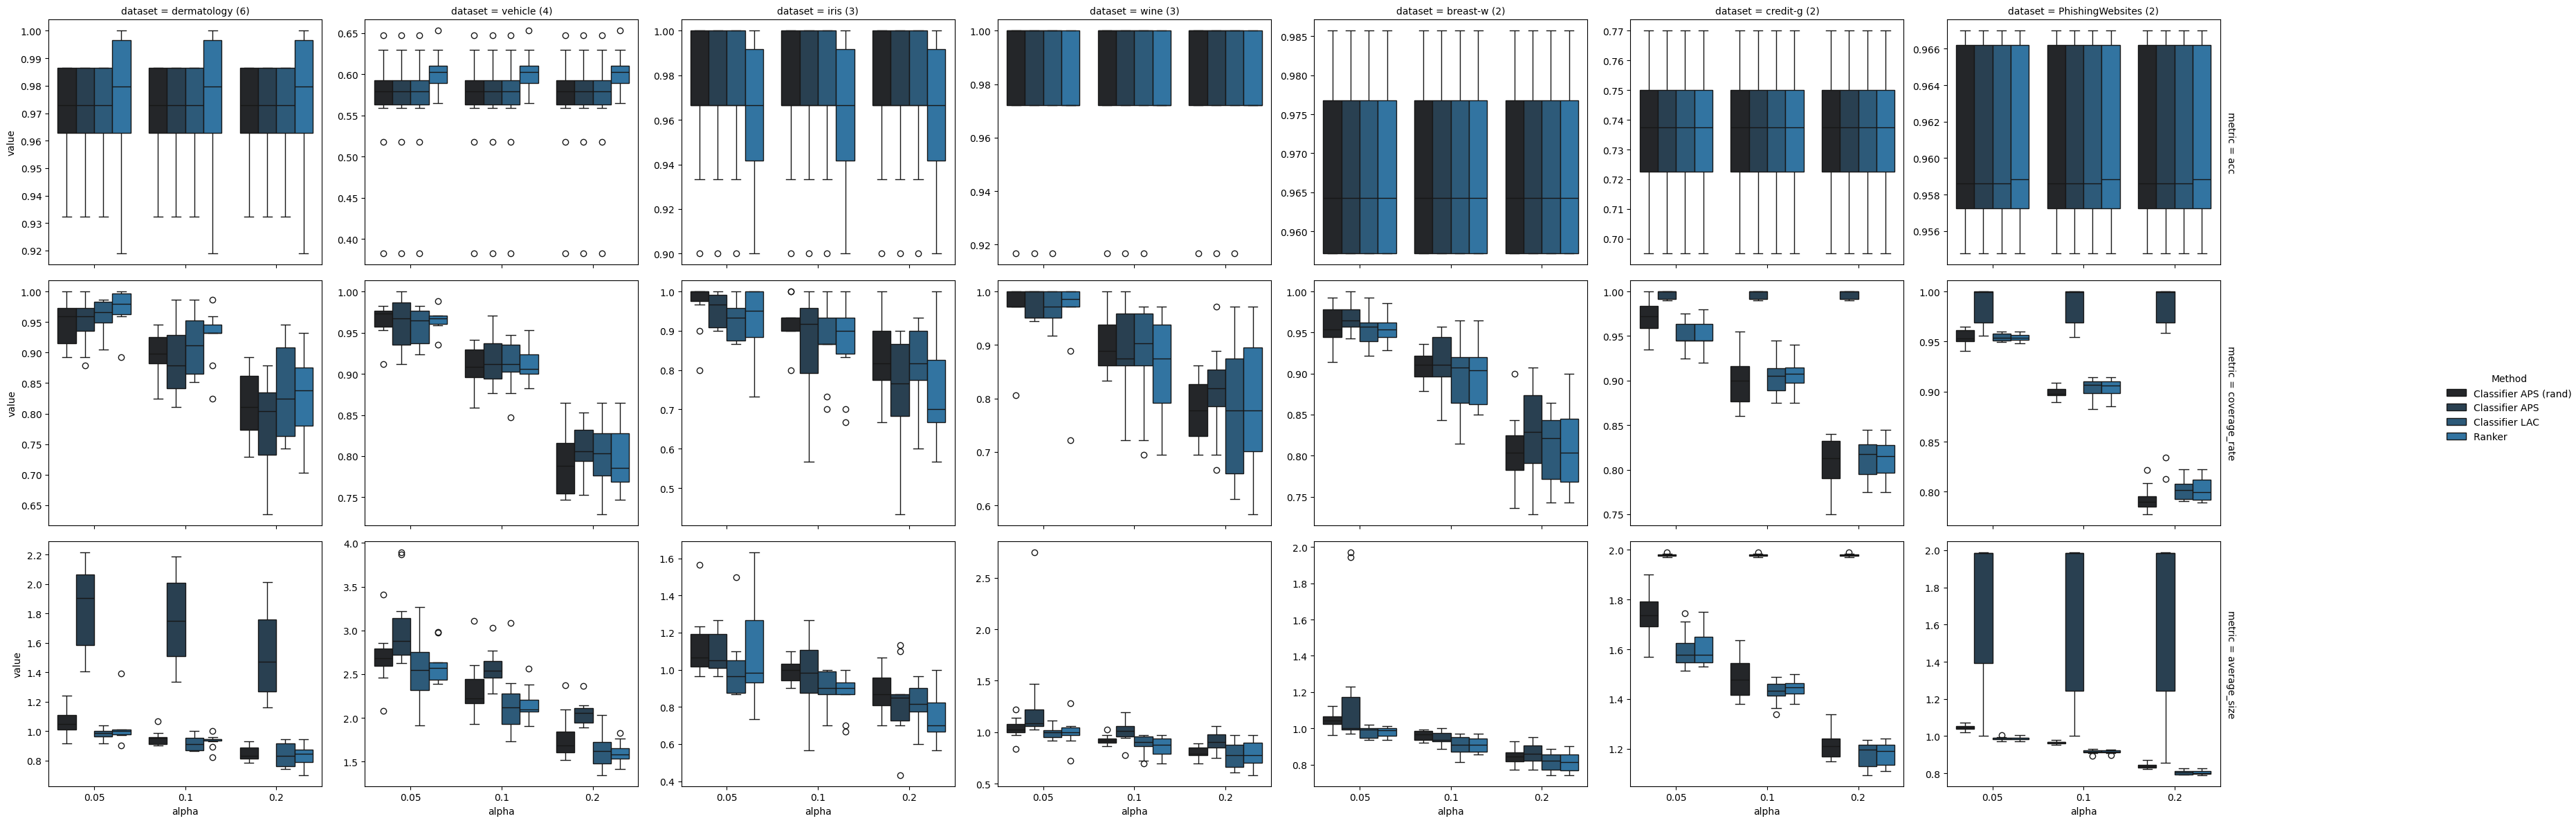

<Figure size 0x0 with 0 Axes>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define columns
group_cols = ['dataset', 'alpha', 'method']
metrics_max = ['acc', 'coverage_rate']
metrics_min = ['average_size']
metrics = metrics_max + metrics_min

# Melt the original result_df to long format for seaborn
melted_df = result_df.melt(id_vars=group_cols, value_vars=metrics, var_name='metric', value_name='value')

# Create FacetGrid with a row per metric
g = sns.FacetGrid(
    melted_df, col="dataset", row="metric", margin_titles=True,
    despine=False, sharey=False, height=4, aspect=1.2
)

# Map boxplots with hue for method separation
g.map_dataframe(sns.boxplot, x="alpha", y="value", hue="method", dodge=True)

# Add a legend
g.add_legend(title="Method")
g.legend.set_bbox_to_anchor((1.05, 0.5))

# Improve labels and titlesimport seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define columns
group_cols = ['dataset', 'alpha', 'method']
metrics_max = ['acc', 'coverage_rate']
metrics_min = ['average_size']
metrics = metrics_max + metrics_min

# Filter the DataFrame to include specific datasets and alphas
# Adjust these lists based on your data
selected_datasets = ['Dataset1', 'Dataset2']  # Replace with actual dataset names
selected_alphas = [0.1]  # Replace with actual alpha values

filtered_df = result_df[
    result_df['dataset'].isin(selected_datasets) &
    result_df['alpha'].isin(selected_alphas)
]

# Melt the filtered DataFrame to long format for seaborn
melted_df = filtered_df.melt(id_vars=group_cols, value_vars=metrics, var_name='metric', value_name='value')

# Create a grouped boxplot using catplot
g = sns.catplot(
    data=melted_df,
    x='alpha', y='value', hue='method',  # X-axis shows alpha, colored by method
    col='dataset', row='metric',  # Separate columns for datasets and rows for metrics
    kind='box', dodge=True,  # Dodge to separate methods
    sharey=False,  # Independent y-axis for each metric
    height=4, aspect=1.2  # Adjust size
)

# Add a legend outside the plot
g.add_legend(title="Method")
g.legend.set_bbox_to_anchor((1.05, 0.5))

# Improve titles and labels
g.set_axis_labels("Alpha", "Value")
g.set_xticklabels(rotation=45)  # Rotate x-axis labels for readability
g.set_titles(row_template="{row_name}", col_template="{col_name}")  # Clearer titles

plt.tight_layout()  # Ensure no clipping
plt.show()

g.set_axis_labels("Alpha", "Value")  
g.set_xticklabels(rotation=45)  
g.set_titles(row_template="{row_name}", col_template="{col_name}")  

plt.show()
